# Notebook to analyze data with interactive graphs

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [2]:
# Get the path to the data folder
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

# Load the csv files created by the process.py script
gdp_data = pd.read_csv(f'{DATA_PATH}/processed/clean_gdp_data.csv').rename(columns = {'value': 'us_gdp'})
spy_data = pd.read_csv(f'{DATA_PATH}/processed/clean_stock_data.csv')[['date', 'adjusted_close']].rename(columns = {'adjusted_close': 'sp500'})

# Format the date columns as datetime and set them as index column
gdp_data['date'] = gdp_data['date'].apply(pd.to_datetime)
gdp_data.set_index('date', inplace=True)
spy_data['date'] = spy_data['date'].apply(pd.to_datetime)
spy_data.set_index('date', inplace=True)

# Join the data and calculate the percentage growths
close_data = gdp_data.join(spy_data).sort_index()
data = close_data.join(close_data.pct_change(1).rename(columns = {'us_gdp': 'us_gdp_growth', 'sp500': 'sp500_growth'})).sort_index()

In [3]:
spy_data

,sp500
date,
2000-01-01,96.1816
2000-04-01,98.7221
2000-07-01,95.6047
2000-10-01,94.7578
2001-01-01,86.8239
...,...
2022-01-01,467.3566
2022-04-01,445.7756
2022-07-01,373.9563


In [4]:
data

,us_gdp,sp500,us_gdp_growth,sp500_growth
date,,,,
2002-01-01,3263.869,76.6199,NaN,NaN
2002-04-01,3362.508,76.9852,0.030221,0.004768
2002-07-01,3401.820,66.7619,0.011691,-0.132796
2002-10-01,3460.159,55.4257,0.017149,-0.169800
2003-01-01,3340.163,60.0794,-0.034679,0.083963
...,...,...,...,...
2021-07-01,4916.402,418.3629,0.005228,0.083641
2021-10-01,5110.951,420.7755,0.039571,0.005767
2022-01-01,4855.857,467.3566,-0.049911,0.110703


In [5]:
# Write a latex label with summary statistics

data_info = data.describe()
data_info.columns = ['US GDP','SPY 500', 'GDP Growth', 'SPY Growth']

with open('../reports/tables/summary_statistics.tex','w') as tf:
    tf.write(data_info.style.to_latex().replace('%', '\%'))

data_info

,US GDP,SPY 500,GDP Growth,SPY Growth
count,83.000000,83.000000,82.000000,82.000000
mean,4138.823892,162.204101,0.005660,0.023073
std,459.801280,102.657838,0.028586,0.083613
min,3263.869000,55.425700,-0.063206,-0.215656
25%,3825.890000,87.304400,-0.018486,-0.008408
50%,4046.533000,112.993400,0.014289,0.033118
75%,4505.344500,216.386200,0.025628,0.069805
max,5110.951000,467.356600,0.084225,0.201649


In [6]:
# What is the correlation between the two variables

data[['us_gdp', 'sp500']].corr()

,us_gdp,sp500
us_gdp,1.000000,0.913062
sp500,0.913062,1.000000


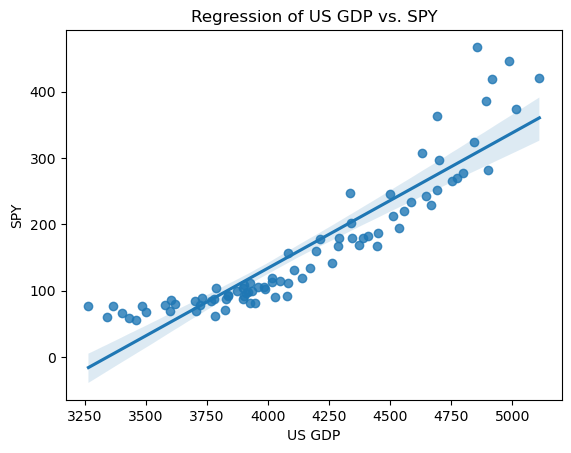

In [7]:
fig = sns.regplot(x=data.us_gdp, y=data.sp500).set(xlabel='US GDP', ylabel='SPY', title='Regression of US GDP vs. SPY')

plt.savefig("../reports/figures/regression.svg")

In [8]:
# Make the two series to start at 100

data_ext = data.copy()

data_ext['us_gdp_100'] = 100*np.exp(np.nan_to_num(data['us_gdp_growth'].cumsum()))
data_ext['sp500_100'] = 100*np.exp(np.nan_to_num(data['sp500_growth'].cumsum()))

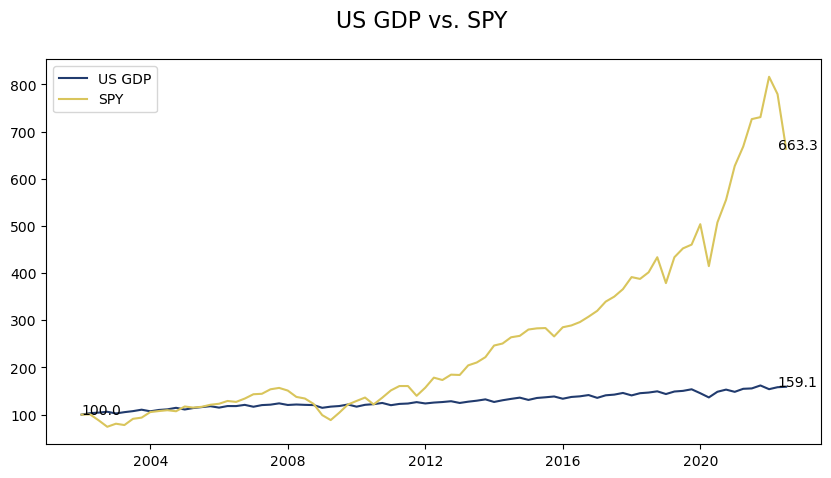

In [9]:
# Plot the two series both starting at 100

fig1, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data_ext.us_gdp_100, color=sns.color_palette("cividis")[0])
ax1.plot(data_ext.sp500_100, color=sns.color_palette("cividis")[-1])

fig1.suptitle('US GDP vs. SPY', fontsize=16)

ax1.legend(['US GDP', 'SPY'], loc='upper left');

ax1.text(data_ext.us_gdp_100.index[-2], data_ext.us_gdp_100[-1], np.round(data_ext.us_gdp_100[-1], 1))
ax1.text(data_ext.sp500_100.index[-2], data_ext.sp500_100[-1], np.round(data_ext.sp500_100[-1], 1))
ax1.text(data_ext.sp500_100.index[0], data_ext.sp500_100[0], np.round(data_ext.sp500_100[0], 1))

plt.savefig("../reports/figures/growth_starting_at_100.svg")

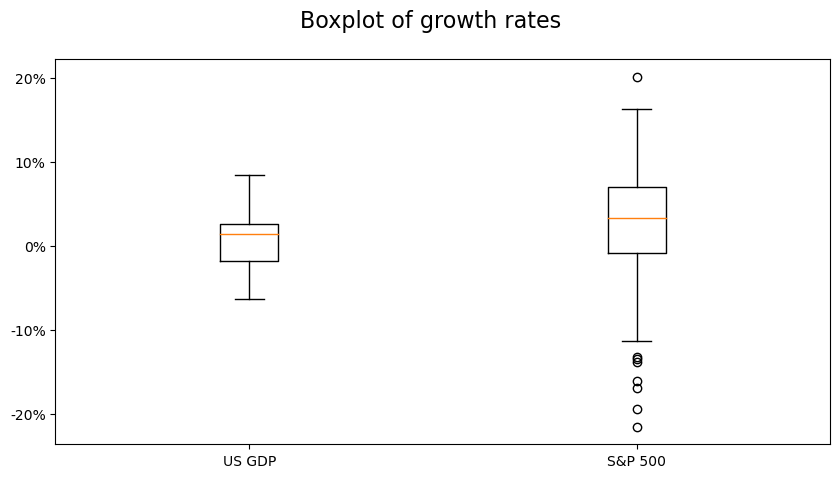

In [10]:
# Add some boxplots

fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Boxplot of growth rates', fontsize=16)
ax2.boxplot(data[['us_gdp_growth', 'sp500_growth']].dropna())
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.set_xticks([1, 2], ['US GDP', 'S&P 500']);

plt.savefig("../reports/figures/boxplots.svg")

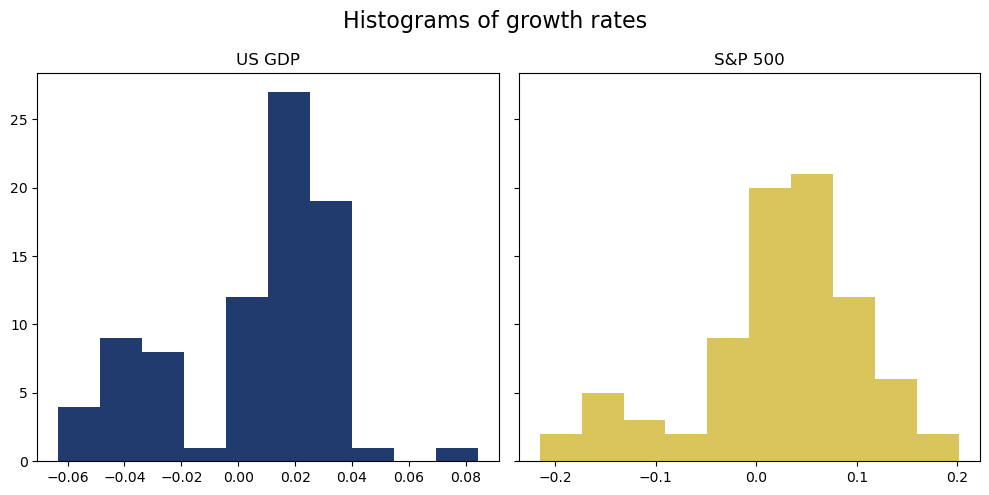

In [11]:
# Add some histograms

fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, tight_layout=True)
fig3.suptitle('Histograms of growth rates', fontsize=16)

ax3[0].set_title('US GDP')
ax3[1].set_title('S&P 500')

ax3[0].hist(data.us_gdp_growth, color = sns.color_palette("cividis")[0])
ax3[1].hist(data.sp500_growth, color = sns.color_palette("cividis")[-1]);

plt.savefig("../reports/figures/histograms.svg")

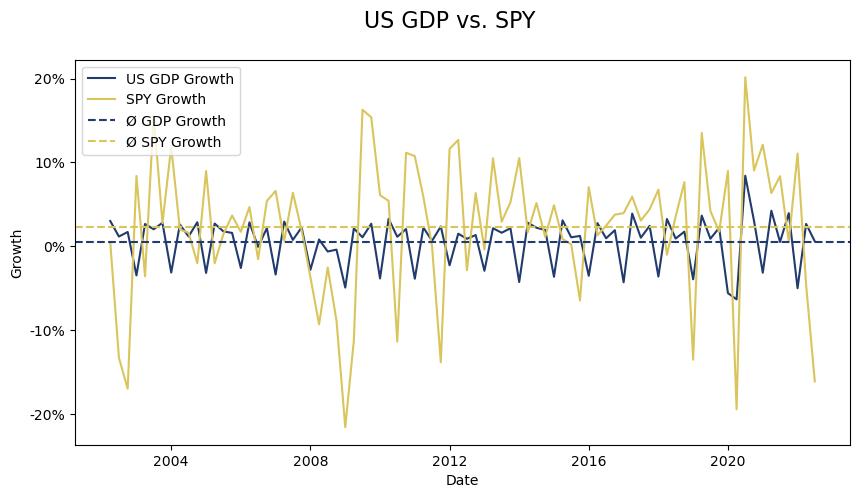

In [12]:
# Plot the growth rates and the average growth over that period

fig4, ax4 = plt.subplots(figsize=(10, 5))

ax4.plot(data.us_gdp_growth, color=sns.color_palette("cividis")[0])
ax4.plot(data.sp500_growth, color=sns.color_palette("cividis")[-1])

ax4.axhline(y=np.nanmean(data.us_gdp_growth), color=sns.color_palette("cividis")[0], linestyle='dashed')
ax4.axhline(y=np.nanmean(data.sp500_growth), color=sns.color_palette("cividis")[-1], linestyle='dashed')

ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig4.suptitle('US GDP vs. SPY', fontsize=16)
ax4.set_ylabel('Growth')
ax4.set_xlabel('Date')
ax4.legend(['US GDP Growth', 'SPY Growth', 'Ø GDP Growth', 'Ø SPY Growth'], loc='upper left');

plt.savefig("../reports/figures/average_growth.svg")

# Analysis with a sample of countries

First, we load the income data retrieved from the World Bank API, since it contains three variables we will be using for our analysis: income level, region and the ISO 2 codes, which will be used to merge the with the gdp and the stock indexes data.

In [13]:
income_data = pd.read_csv(f'{DATA_PATH}/processed/clean_income_data.csv', usecols=["iso2Code", "name", "region", "incomeLevel"])
income_data.rename(columns={"iso2Code":"country", "incomeLevel":"income level"}, inplace=True)
income_data.head()

,country,name,region,income level
0,AF,Afghanistan,South Asia,Low income
1,AL,Albania,Europe & Central Asia,Upper middle income
2,DZ,Algeria,Middle East & North Africa,Lower middle income
3,AS,American Samoa,East Asia & Pacific,Upper middle income
4,AD,Andorra,Europe & Central Asia,High income


Now, we load the data collected for the analysis. It consists of three different data sets, namely:
1. Income level data (already loaded)
2. GDP by for a sample of countries
3. Major stock indexes of a sample of countries

We will combine these three sets of data to perform the same analysis as before, now differetiating by income level and region of the countries in the data. Income level data was obtained from the World Bank API, GDP data from the FRED API using the freadapi python wrapper (only a small subsets of countries had existing data in FRED), and finally, stock indexes were obtained from the Yahoo Finance using the yfinance python package.

In [14]:
gdp_data_all = pd.read_csv(f'{DATA_PATH}/processed/clean_gdp_data_all.csv')
gdp_data_all.rename(columns={"value":"gdp"}, inplace=True)
gdp_data_all["date"] = pd.to_datetime(gdp_data_all.q_date)
gdp_data_all.set_index(["country", "date"], inplace=True)
gdp_data_all.drop("q_date", axis=1, inplace=True)
gdp_data_all.rename(columns={"gdp":"GDP"}, inplace=True)
gdp_data_all.head()

GDP
country date                
AR      2004-01-01  118842.8
        2004-04-01  117587.7
        2004-07-01  123517.5
        2004-10-01  125167.3
        2005-01-01  128814.4

In [15]:
stock_data_all = pd.read_csv(f'{DATA_PATH}/processed/clean_stock_data_all.csv', usecols=["q_date", "value", "country"])
stock_data_all.rename(columns={"value":"stock_index"}, inplace=True)
stock_data_all["date"] = pd.to_datetime(stock_data_all.q_date)
stock_data_all.set_index(["country", "date"], inplace=True)
stock_data_all.drop("q_date", axis=1, inplace=True)
stock_data_all.rename(columns={"stock_index":"Stock Index"}, inplace=True)
stock_data_all.head()

Stock Index
country date                   
US      1927-10-01    17.660000
        1928-01-01    17.760000
        1928-04-01    18.910000
        1928-07-01    18.980000
        1928-10-01    21.360001

In [16]:
data_all = gdp_data_all.join(stock_data_all)
data_all = data_all.sort_index()
data_all.head()

GDP  Stock Index
country date                             
AR      2004-01-01  118842.8  1101.500000
        2004-04-01  117587.7  1211.300049
        2004-07-01  123517.5   951.200012
        2004-10-01  125167.3  1160.099976
        2005-01-01  128814.4  1369.500000

We will retain information only from three countries: Indonesia (lower-middle income), Mexico (upper-middle income) and the US (high income).

In [17]:
data_all = data_all.loc[["ID", "MX"]]
data_all.head()

GDP  Stock Index
country date                                 
ID      2000-01-01  1.012908e+09   700.218018
        2000-04-01  1.007085e+09   570.901001
        2000-07-01  1.031622e+09   503.855988
        2000-10-01  1.061287e+09   432.239014
        2001-01-01  1.053724e+09   410.204987

Let's see if a there are missing values

In [18]:
np.isnan(data_all).sum()

GDP            0
Stock Index    0
dtype: int64

In [19]:
data_all.reset_index().groupby("country").describe()

GDP                                                          \
         count          mean           std           min           25%   
country                                                                  
ID        91.0  1.871751e+09  6.055461e+08  1.007085e+09  1.310706e+09   
MX       119.0  3.640065e+06  6.601512e+05  2.434251e+06  3.193807e+06   

                                                  Stock Index                \
                  50%           75%           max       count          mean   
country                                                                       
ID       1.807993e+09  2.417032e+09  2.919293e+09        91.0   3326.695588   
MX       3.649058e+06  4.247532e+06  4.645932e+06       119.0  24360.847759   

                                                                             \
                  std          min          25%           50%           75%   
country                                                                       
ID        2179.680667   375.032013  1117.027039   3707.487061   5191.841064   
MX       18088.064112  1662.400024  5774.334961  25117.320312  42229.794922   

                       
                  max  
country                
ID        7078.759766  
MX       56609.539062

What is the correlations between the two variables, without considering the cross-section?

In [20]:
data_all.corr()

,GDP,Stock Index
GDP,1.000000,-0.525986
Stock Index,-0.525986,1.000000


What if we include the cross-section?

In [21]:
data_all.reset_index("country").groupby("country").corr()

GDP  Stock Index
country                                   
ID      GDP          1.000000     0.976335
        Stock Index  0.976335     1.000000
MX      GDP          1.000000     0.955407
        Stock Index  0.955407     1.000000

We see that the correlation between the two variables for the two countries is very high and positive.

In [22]:
income_data.set_index("country", inplace=True)

In [23]:
data_all = data_all.join(income_data)
data_all.head()

GDP  Stock Index       name               region  \
country date                                                                    
ID      2000-01-01  1.012908e+09   700.218018  Indonesia  East Asia & Pacific   
        2000-04-01  1.007085e+09   570.901001  Indonesia  East Asia & Pacific   
        2000-07-01  1.031622e+09   503.855988  Indonesia  East Asia & Pacific   
        2000-10-01  1.061287e+09   432.239014  Indonesia  East Asia & Pacific   
        2001-01-01  1.053724e+09   410.204987  Indonesia  East Asia & Pacific   

                           income level  
country date                             
ID      2000-01-01  Lower middle income  
        2000-04-01  Lower middle income  
        2000-07-01  Lower middle income  
        2000-10-01  Lower middle income  
        2001-01-01  Lower middle income

In [24]:
data_all.rename(columns={"region":"Region", "income level":"Income level"}, inplace=True)
data_all.head()

GDP  Stock Index       name               Region  \
country date                                                                    
ID      2000-01-01  1.012908e+09   700.218018  Indonesia  East Asia & Pacific   
        2000-04-01  1.007085e+09   570.901001  Indonesia  East Asia & Pacific   
        2000-07-01  1.031622e+09   503.855988  Indonesia  East Asia & Pacific   
        2000-10-01  1.061287e+09   432.239014  Indonesia  East Asia & Pacific   
        2001-01-01  1.053724e+09   410.204987  Indonesia  East Asia & Pacific   

                           Income level  
country date                             
ID      2000-01-01  Lower middle income  
        2000-04-01  Lower middle income  
        2000-07-01  Lower middle income  
        2000-10-01  Lower middle income  
        2001-01-01  Lower middle income

Now, we will obtain the percentage changes of the two series, and make them start at 100 using those changes. This has to be done for each country. To avoid mistakes, it will be done in a loop. Although inefficient, calculations using grouped operations might be too cumbersome and could lead to errors. Also, the data will be filtrated to keep only data from year 2000 onwards.

In [25]:
data_all = data_all.loc[data_all.index.get_level_values("date") >= "2000-01-01", :]
countries = data_all.index.get_level_values("country").unique()
print(countries)

Index(['ID', 'MX'], dtype='object', name='country')


In [26]:
# Do the calculations for each country
data_all.reset_index(inplace=True)
data = pd.DataFrame()
for c in countries:
    aux_d = data_all.loc[data_all.country == c, :]
    aux_d.sort_values("date", inplace=True)
    aux_d.loc[:, "GDP growth"] = aux_d.GDP.pct_change(1)
    aux_d.loc[:, "Stock Index growth"] = aux_d["Stock Index"].pct_change(1)
    aux_d.loc[:, "GDP 100"] = 100*np.exp(np.nan_to_num(aux_d["GDP growth"].cumsum()))
    aux_d.loc[:, "Stock Index 100"] = 100*np.exp(np.nan_to_num(aux_d["Stock Index growth"].cumsum()))
    data = pd.concat([data, aux_d])

data.set_index(["country", "date"], inplace=True)
data.head()


/var/folders/d4/9bzzss954hn8n537wrw0mjn80000gn/T/ipykernel_27812/4140197498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_d.sort_values("date", inplace=True)
/var/folders/d4/9bzzss954hn8n537wrw0mjn80000gn/T/ipykernel_27812/4140197498.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_d.loc[:, "GDP growth"] = aux_d.GDP.pct_change(1)
/var/folders/d4/9bzzss954hn8n537wrw0mjn80000gn/T/ipykernel_27812/4140197498.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

GDP  Stock Index       name               Region  \
country date                                                                    
ID      2000-01-01  1.012908e+09   700.218018  Indonesia  East Asia & Pacific   
        2000-04-01  1.007085e+09   570.901001  Indonesia  East Asia & Pacific   
        2000-07-01  1.031622e+09   503.855988  Indonesia  East Asia & Pacific   
        2000-10-01  1.061287e+09   432.239014  Indonesia  East Asia & Pacific   
        2001-01-01  1.053724e+09   410.204987  Indonesia  East Asia & Pacific   

                           Income level  GDP growth  Stock Index growth  \
country date                                                              
ID      2000-01-01  Lower middle income         NaN                 NaN   
        2000-04-01  Lower middle income   -0.005749           -0.184681   
        2000-07-01  Lower middle income    0.024364           -0.117437   
        2000-10-01  Lower middle income    0.028756           -0.142138   
        2001-01-01  Lower middle income   -0.007126           -0.050976   

                       GDP 100  Stock Index 100  
country date                                     
ID      2000-01-01  100.000000       100.000000  
        2000-04-01   99.426731        83.136939  
        2000-07-01  101.878923        73.925063  
        2000-10-01  104.851091        64.130119  
        2001-01-01  104.106581        60.942917

In [27]:
data.tail()

GDP   Stock Index    name  \
country date                                          
MX      2021-07-01  4449655.3  50376.890625  Mexico   
        2021-10-01  4463474.5  51060.050781  Mexico   
        2022-01-01  4514443.4  52941.011719  Mexico   
        2022-04-01  4556173.9  56609.539062  Mexico   
        2022-07-01  4636540.8  47743.148438  Mexico   

                                        Region         Income level  \
country date                                                          
MX      2021-07-01  Latin America & Caribbean   Upper middle income   
        2021-10-01  Latin America & Caribbean   Upper middle income   
        2022-01-01  Latin America & Caribbean   Upper middle income   
        2022-04-01  Latin America & Caribbean   Upper middle income   
        2022-07-01  Latin America & Caribbean   Upper middle income   

                    GDP growth  Stock Index growth     GDP 100  \
country date                                                     
MX      2021-07-01   -0.005290            0.044170  144.461735   
        2021-10-01    0.003106            0.013561  144.911084   
        2022-01-01    0.011419            0.036838  146.575323   
        2022-04-01    0.009244            0.069295  147.936514   
        2022-07-01    0.017639           -0.156624  150.569135   

                    Stock Index 100  
country date                         
MX      2021-07-01      1121.739368  
        2021-10-01      1137.054868  
        2022-01-01      1179.723019  
        2022-04-01      1264.370415  
        2022-07-01      1081.069348

In [28]:
# Write a latex label with summary statistics

data_info = data.reset_index("country").groupby("country").describe()

with open('../reports/tables/summary_statistics_all.tex','w') as tf:
    tf.write(data_info.style.to_latex().replace('%', '\%'))

data_info

GDP                                                          \
        count          mean           std           min           25%   
country                                                                 
ID       91.0  1.871751e+09  6.055461e+08  1.007085e+09  1.310706e+09   
MX       91.0  3.911306e+06  4.910995e+05  3.181912e+06  3.472522e+06   

                                                  Stock Index                \
                  50%           75%           max       count          mean   
country                                                                       
ID       1.807993e+09  2.417032e+09  2.919293e+09        91.0   3326.695588   
MX       3.815792e+06  4.404713e+06  4.645932e+06        91.0  30838.043779   

         ...     GDP 100             Stock Index 100                          \
         ...         75%         max           count        mean         std   
country  ...                                                                   
ID       ...  240.203447  291.603628            91.0  786.700243  580.749354   
MX       ...  139.630704  150.569135            91.0  613.369899  349.100679   

                                                                      
               min         25%         50%          75%          max  
country                                                               
ID       55.935138  194.845464  839.468339  1290.398209  1909.500873  
MX       80.136361  250.413903  724.774600   894.171648  1264.370415  

[2 rows x 48 columns]

Some visualizations

/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


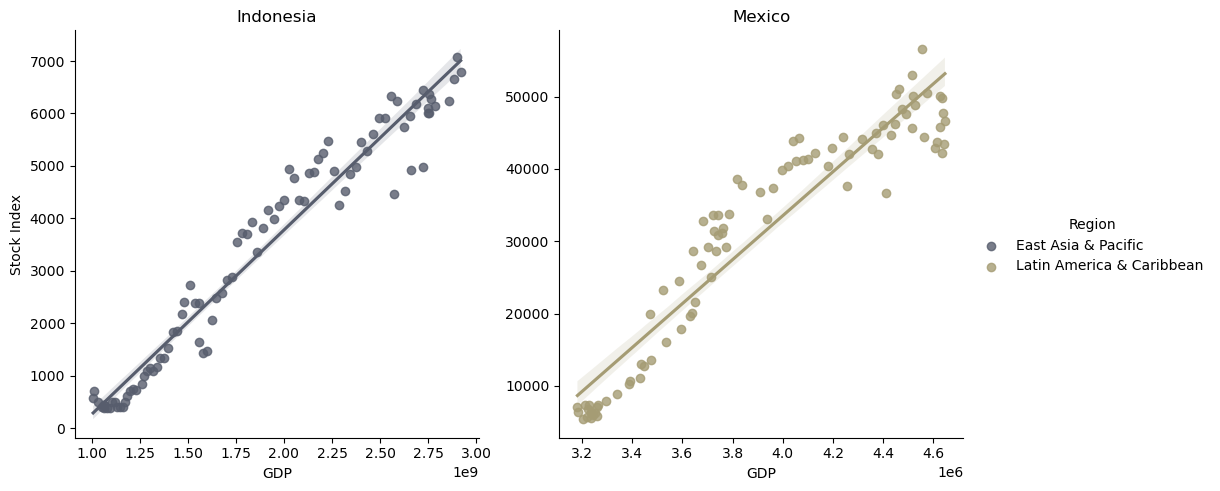

In [29]:
fig = sns.lmplot(data=data.reset_index(), x="GDP", y="Stock Index", col="name", col_wrap=2, sharex=False, sharey=False, hue="Region", palette="cividis")
fig.axes[0].set_title("Indonesia")
fig.axes[1].set_title("Mexico")
plt.savefig("../reports/figures/regression_all_region.svg")

/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/lesfa/miniforge3/envs/scikit_learn/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


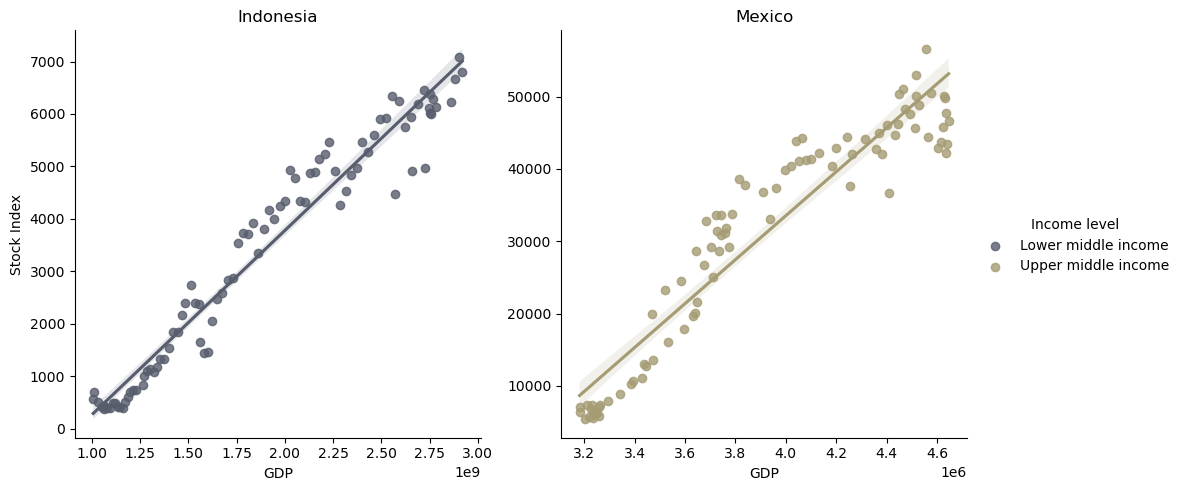

In [30]:
fig = sns.lmplot(data=data.reset_index(), x="GDP", y="Stock Index", col="name", col_wrap=2, sharex=False, sharey=False, hue="Income level", palette="cividis")
fig.axes[0].set_title("Indonesia")
fig.axes[1].set_title("Mexico")
plt.savefig("../reports/figures/regression_all_incomelevel.svg")

Reshaping the data for another visualization

In [31]:
ad1 = data[["name", "GDP 100", "Stock Index 100"]].reset_index().melt(id_vars=["country", "name", "date"], var_name="Variable")
ad1.head()

,country,name,date,Variable,value
0,ID,Indonesia,2000-01-01,GDP 100,100.000000
1,ID,Indonesia,2000-04-01,GDP 100,99.426731
2,ID,Indonesia,2000-07-01,GDP 100,101.878923
3,ID,Indonesia,2000-10-01,GDP 100,104.851091
4,ID,Indonesia,2001-01-01,GDP 100,104.106581


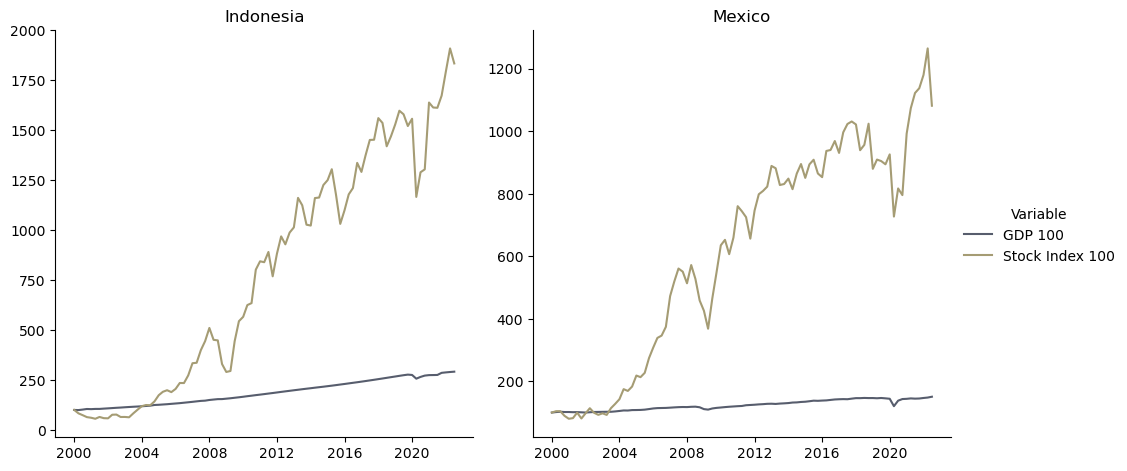

In [32]:
fig = sns.relplot(data=ad1, x="date", y="value", hue="Variable", col="name", col_wrap=2, kind="line", facet_kws=dict(sharey=False, sharex=False), palette="cividis")
fig.axes[0].set_title("Indonesia")
fig.axes[0].set_xlabel("")
fig.axes[0].set_ylabel("")
fig.axes[1].set_title("Mexico")
fig.axes[1].set_xlabel("")
fig.axes[1].set_ylabel("")
plt.savefig("../reports/figures/growth_starting_at_100_all.svg")

Histograms of percent changes for each country

In [33]:
mosaic_plot = [["A", "B"], ["C", "D"]]

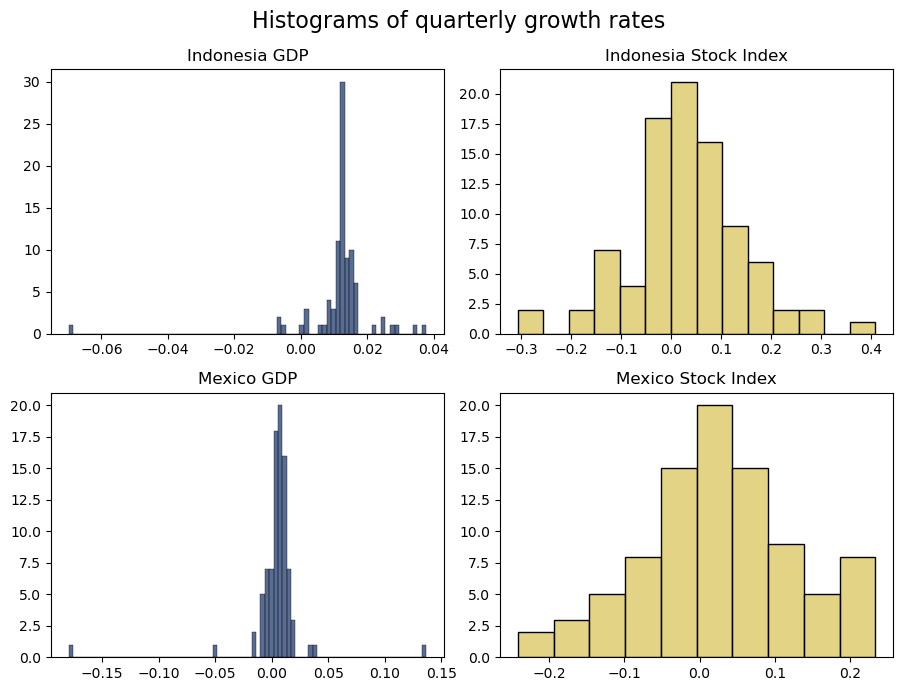

In [34]:
fig = plt.figure(figsize=(9, 7))
axes = fig.subplot_mosaic(mosaic=mosaic_plot)

sns.histplot(data=data.loc["ID"], x="GDP growth", ax=axes["A"], color=sns.color_palette("cividis")[0])
axes["A"].set_xlabel("")
axes["A"].set_ylabel("")
axes["A"].set_title("Indonesia GDP")
sns.histplot(data=data.loc["ID"], x="Stock Index growth", ax=axes["B"], color=sns.color_palette("cividis")[-1])
axes["B"].set_xlabel("")
axes["B"].set_ylabel("")
axes["B"].set_title("Indonesia Stock Index")
sns.histplot(data=data.loc["MX"], x="GDP growth", ax=axes["C"], color=sns.color_palette("cividis")[0])
axes["C"].set_xlabel("")
axes["C"].set_ylabel("")
axes["C"].set_title("Mexico GDP")
sns.histplot(data=data.loc["MX"], x="Stock Index growth", ax=axes["D"], color=sns.color_palette("cividis")[-1])
axes["D"].set_xlabel("")
axes["D"].set_ylabel("")
axes["D"].set_title("Mexico Stock Index")

fig.suptitle("Histograms of quarterly growth rates", fontsize=16)
fig.tight_layout()
fig.savefig("../reports/figures/histograms_growth_rates_all.svg")

Boxplots of the growth rates

In [35]:
mosaic_plot2 = """
A
B
"""

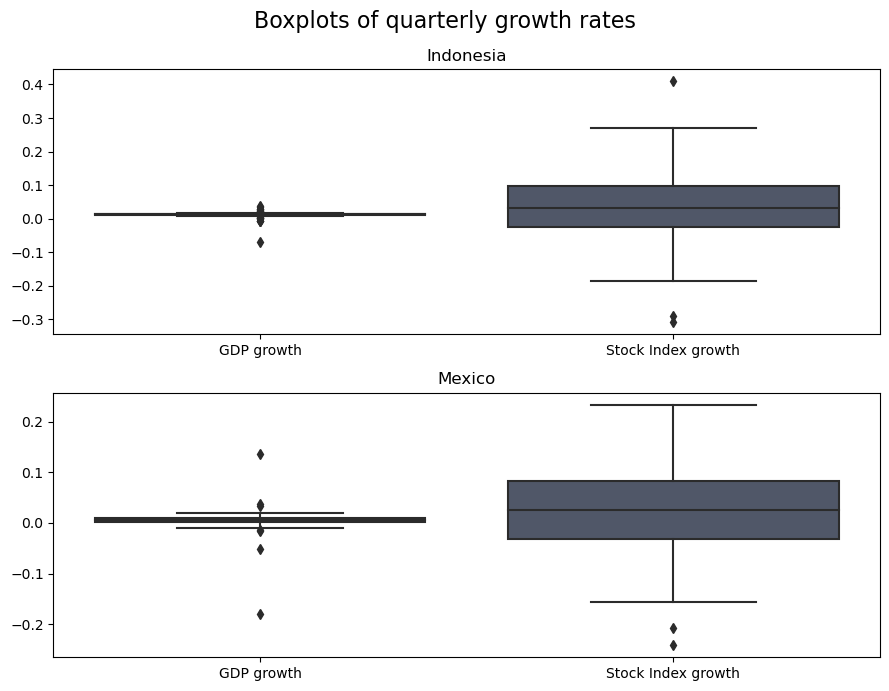

In [36]:
fig = plt.figure(figsize=(9, 7))
axes = fig.subplot_mosaic(mosaic=mosaic_plot2)

sns.boxplot(data=data.loc["ID", ["GDP growth", "Stock Index growth"]].melt(var_name="Variable"), x="Variable", y="value", ax=axes["A"], palette=sns.color_palette("cividis"))
axes["A"].set_xlabel("")
axes["A"].set_ylabel("")
axes["A"].set_title("Indonesia")
sns.boxplot(data=data.loc["MX", ["GDP growth", "Stock Index growth"]].melt(var_name="Variable"), x="Variable", y="value", ax=axes["B"], palette=sns.color_palette("cividis"))
axes["B"].set_xlabel("")
axes["B"].set_ylabel("")
axes["B"].set_title("Mexico")

fig.suptitle("Boxplots of quarterly growth rates", fontsize=16)
fig.tight_layout()
fig.savefig("../reports/figures/boxplots_growth_rates_all.svg")

Plots of quarterly changes

In [37]:
dac = data[["name", "GDP growth", "Stock Index growth"]].melt(id_vars="name", var_name="Variable", ignore_index=False).reset_index()

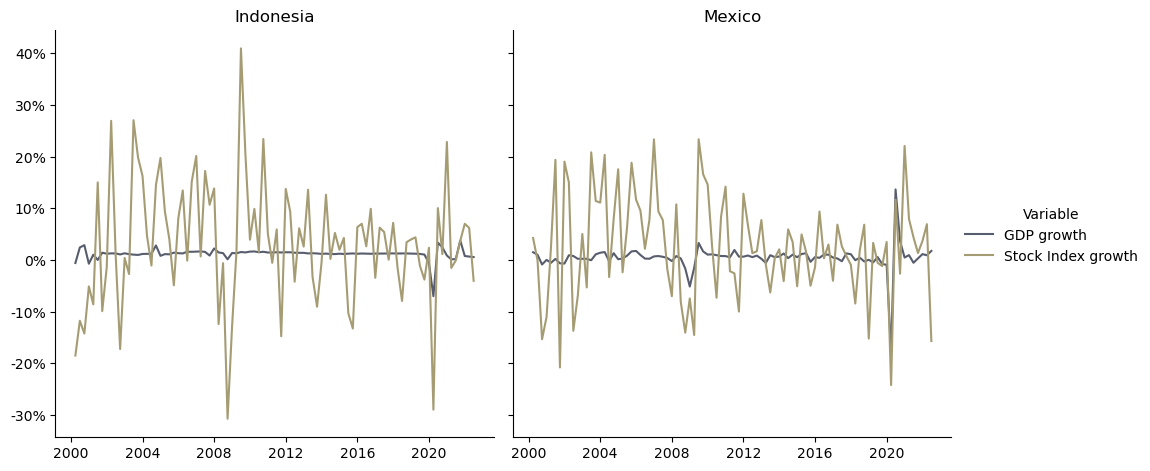

In [38]:
fig = sns.relplot(data=dac, x="date", y="value", col="name", col_wrap=2, facet_kws=dict(sharex=True, sharey=True), hue="Variable", kind="line", palette="cividis")
fig.axes[0].set_title("Indonesia")
fig.axes[0].set_xlabel("")
fig.axes[0].set_ylabel("")
fig.axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig.axes[1].set_title("Mexico")
fig.axes[1].set_xlabel("")
fig.axes[1].set_ylabel("")
fig.axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.savefig("../reports/figures/growth_lineplots_all.svg")